In [230]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic

In [231]:
# import data from ../data/data-agg.csv 
data = pd.read_csv('../data/data-agg.csv')
print(len(data[data['coin']=='2HRK']))

# fill the table with the other relevant values 
data['rom_heads'] = data['heads_heads']/data['N_start_heads_up']
data['rom_tails'] = (data['N_start_tails_up']-data['tails_heads'])/data['N_start_tails_up']

print(len(data))

# duplicate data : 
data_expanded = pd.concat([
    data.assign(heads_indicator=1),
    data.assign(heads_indicator=0)
])
data_expanded = data_expanded.reset_index(drop=True)

# the function that will select the right r based on the indicator heads indicator : 
def get_r(row):
    if row['heads_indicator'] == 1:
        return row['heads_heads']
    else:
        return row['N_start_tails_up'] - row['tails_heads']
# the function that will select the right m based on the indicator heads indicator : 
def get_m(row):
    if row['heads_indicator'] == 1:
        return row['N_start_heads_up']
    else:
        return row['N_start_tails_up']
    
data_expanded['r'] = data_expanded.apply( get_r, axis=1)
data_expanded['m'] = data_expanded.apply( get_m, axis=1)
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']

print(len(data_expanded))
print(data_expanded)

1
211
422
     heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  \
0            244          240               485               515   
1            260          245               505               495   
2            209          260               469               531   
3            530          495              1021               979   
4            533          507              1039               961   
..           ...          ...               ...               ...   
417          517          561              1084              1116   
418          782          844              1626              1674   
419          233          249               478               522   
420          775          746              1523              1477   
421          257          238               496               504   

           person          coin  rom_heads  rom_tails  heads_indicator    r  \
0      frantisekB  20DEM-silver   0.503093   0.533981                1  244   
1  

### Take into account differences between persons, coins and starting state

In [232]:
import statsmodels.api as sm 

In [237]:
# each coefficient represents the contribution of one person to the grand mean let's say. 
# we consider there are 
from statsmodels.regression import linear_model

WLS_model = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)+C(heads_indicator)", data=data_expanded)
result_WLS = WLS_model.fit()

table = sm.stats.anova_lm(result_WLS, typ=2) # Type 2 ANOVA DataFrame
#print(result_WLS.summary())
print(table)

                      sum_sq     df         F        PR(>F)
C(person)           0.109279   47.0  4.210137  4.749816e-15
C(coin)             0.033104   43.0  1.394038  5.848578e-02
C(heads_indicator)  0.000007    1.0  0.011852  9.133746e-01
Residual            0.182797  331.0       NaN           NaN


## AIC

In [238]:
WLS_model_0 = linear_model.WLS.from_formula(formula="(rom) ~ 1", data=data_expanded)
WLS_model_1 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)", data=data_expanded)
WLS_model_11 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(coin)", data=data_expanded)
WLS_model_2 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)", data=data_expanded)
WLS_model_3 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(coin)+C(person)+C(heads_indicator)", data=data_expanded)
result_WLS_0 = WLS_model_0.fit()
result_WLS_1 = WLS_model_1.fit()
result_WLS_11 = WLS_model_11.fit()
result_WLS_2 = WLS_model_2.fit()
result_WLS_3 = WLS_model_3.fit()
print(f"\nAIC for the WLS_0: {result_WLS_0.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_WLS_1.aic:.2f}")
print(f"\nAIC for the WLS_11: {result_WLS_11.aic:.2f}")
print(f"\nAIC for the WLS_2: {result_WLS_2.aic:.2f}")
print(f"\nAIC for the WLS_3: {result_WLS_3.aic:.2f}")
# lower AIC is better ! we selecti model 2 with coins and persons only 


# LLR TODO 
#print("first")
#result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)
print("second")
result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)
#print("third")
#result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)


AIC for the WLS_0: -1823.84

AIC for the WLS_1: -1904.66

AIC for the WLS_11: -1786.06

AIC for the WLS_2: -1890.53

AIC for the WLS_3: -1888.55
second


(np.float64(69.87118662538637),
 np.float64(0.0044253930964533285),
 np.float64(42.0))

In [239]:
#import patsy
#y_, X_ = patsy.dmatrices("(rom) ~ C(person)+C(coin)+C(heads_indicator)", data_expanded, return_type="matrix")
#print(np.linalg.matrix_rank(X_))
#print(X_[:,0])
#print(X_.shape)

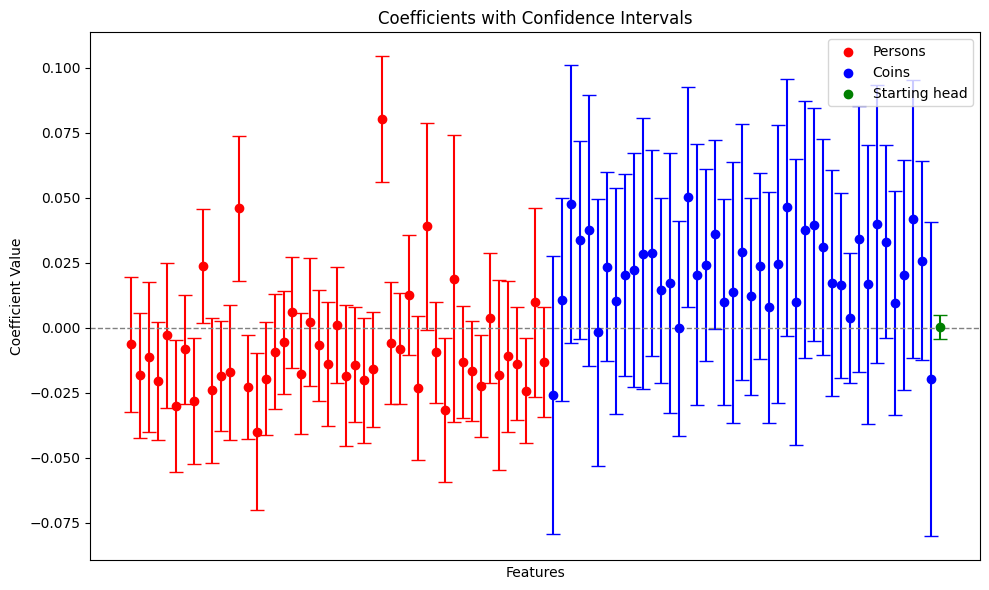

In [240]:
import re

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]


# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else "green"
    for feature in feature_names
]
# Create the plot
plt.figure(figsize=(10, 6))
# Clean the feature names

for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry
plt.legend(loc='upper right')

# Add labels and title
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

# Diagnostic plots : 
- qq plot 

<Figure size 800x600 with 0 Axes>

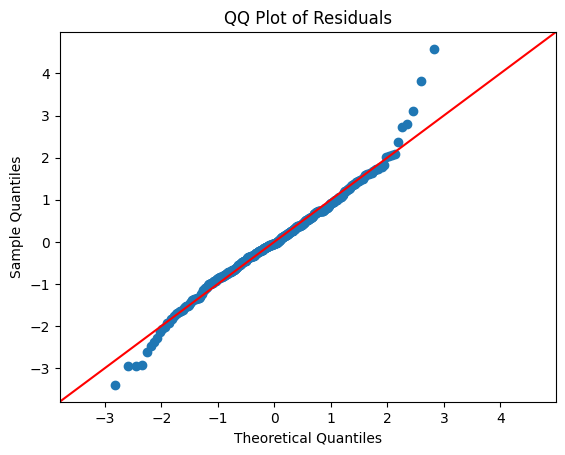

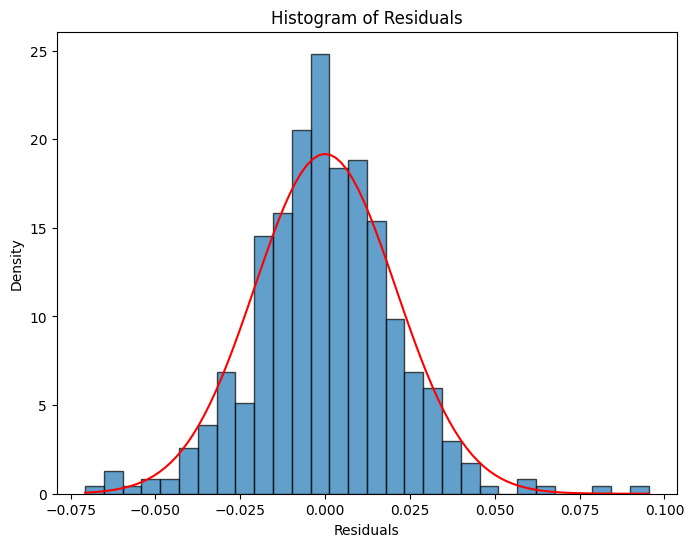

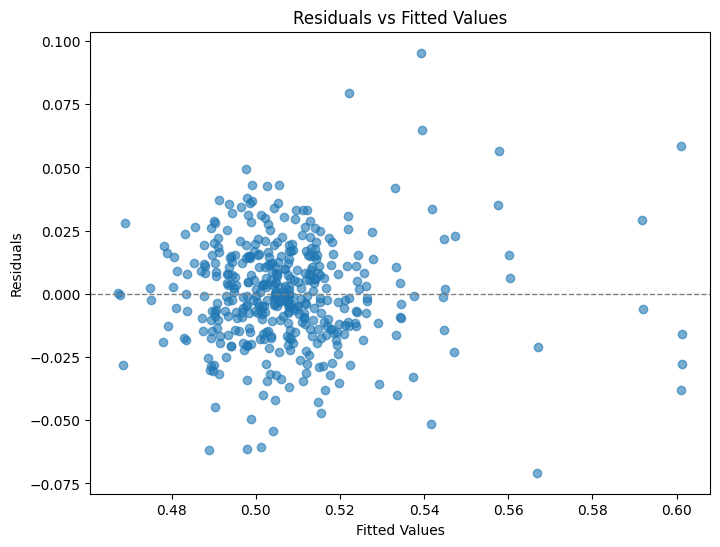

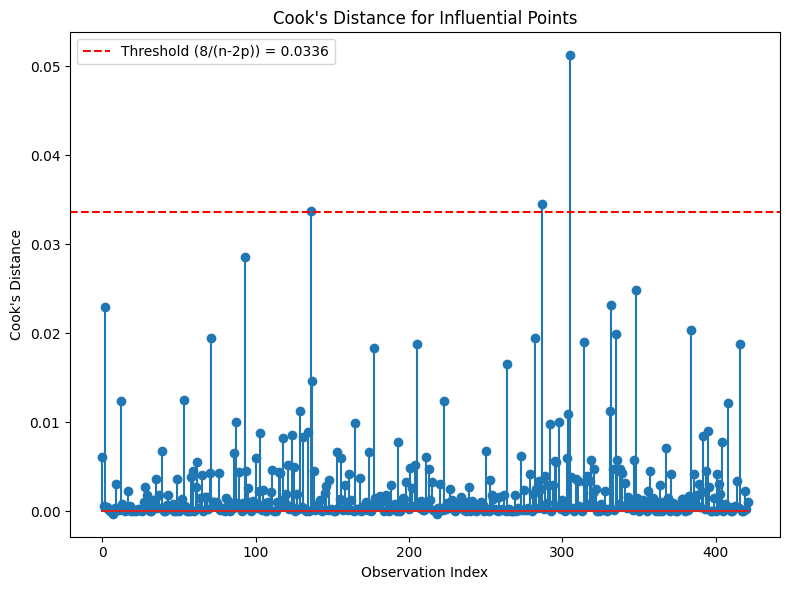

Influential points (index): [136 287 305]


In [ ]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals = result_WLS.resid # actual values minus the predicted value
fitted_values = result_WLS.fittedvalues # ok predicted values 
standardized_residuals = residuals / np.std(residuals) # standardized residuals
 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals), scale=np.std(residuals)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Scale-Location Plot (Spread of residuals)
'''
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Scale-Location Plot')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.show()
'''

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X = WLS_model.exog  # Design matrix
W = np.diag(WLS_model.weights)  # Diagonal weight matrix
n = X.shape[0]  
p = X.shape[1] 

# matrix H
H = W @ X @ np.linalg.inv(X.T @ W @ X) @ X.T @ W
leverage = np.diag(H)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals = residuals / np.std(residuals)
cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold = 8 / (n - 2 * p)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points = np.where(cooks_d > threshold)[0] # extreme points 
print(f"Influential points (index): {influential_points}")

In [208]:
# Identify problematic points : 
number_of_extreme_points = 2

# the 2 highest values (par exemple) that we seen on the qq plot correspond to : 
largest_residuals_indices = np.argsort(np.abs(residuals))[-number_of_extreme_points:]  # Indices of the two largest (in val absolute)residuals
# go to corresponding rows in data_expanded
largest_residuals_data = data_expanded.iloc[largest_residuals_indices]
# Extract persons and coins
persons = largest_residuals_data['person'].values
coins = largest_residuals_data['coin'].values

# Display the results
for i, index in enumerate(largest_residuals_indices):
    print(f"Residual Index: {index}, Person: {persons[i]}, Coin: {coins[i]}, Residual Value: {residuals[index]}")


Residual Index: 287, Person: EJ, Coin: 50CZK, Residual Value: 0.07960125410990349
Residual Index: 314, Person: MagdaMatetovici, Coin: 1CAD, Residual Value: 0.09537165170924133
